# **Human Activity Recognition using TensorFlow(LSTM + CNN)**

## **Import the libraries**

In [1]:
!pip install pafy youtube-dl moviepy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 13.5 MB/s eta 0:00:00


In [2]:
import os
import cv2
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
from moviepy.editor import*
%matplotlib inline
from sklearn.model_selection import train_test_split

In [3]:
from tensorflow.keras.layers import*
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [4]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

## **Step 1 - Downloading and visualizing data with its labels**

In [5]:
%%capture
# Download the dataset
!wget --no-check-certificate https://www.crcv.ucf.edu/data/UCF50.rar

#Extract the Dataset
!unrar x UCF50.rar

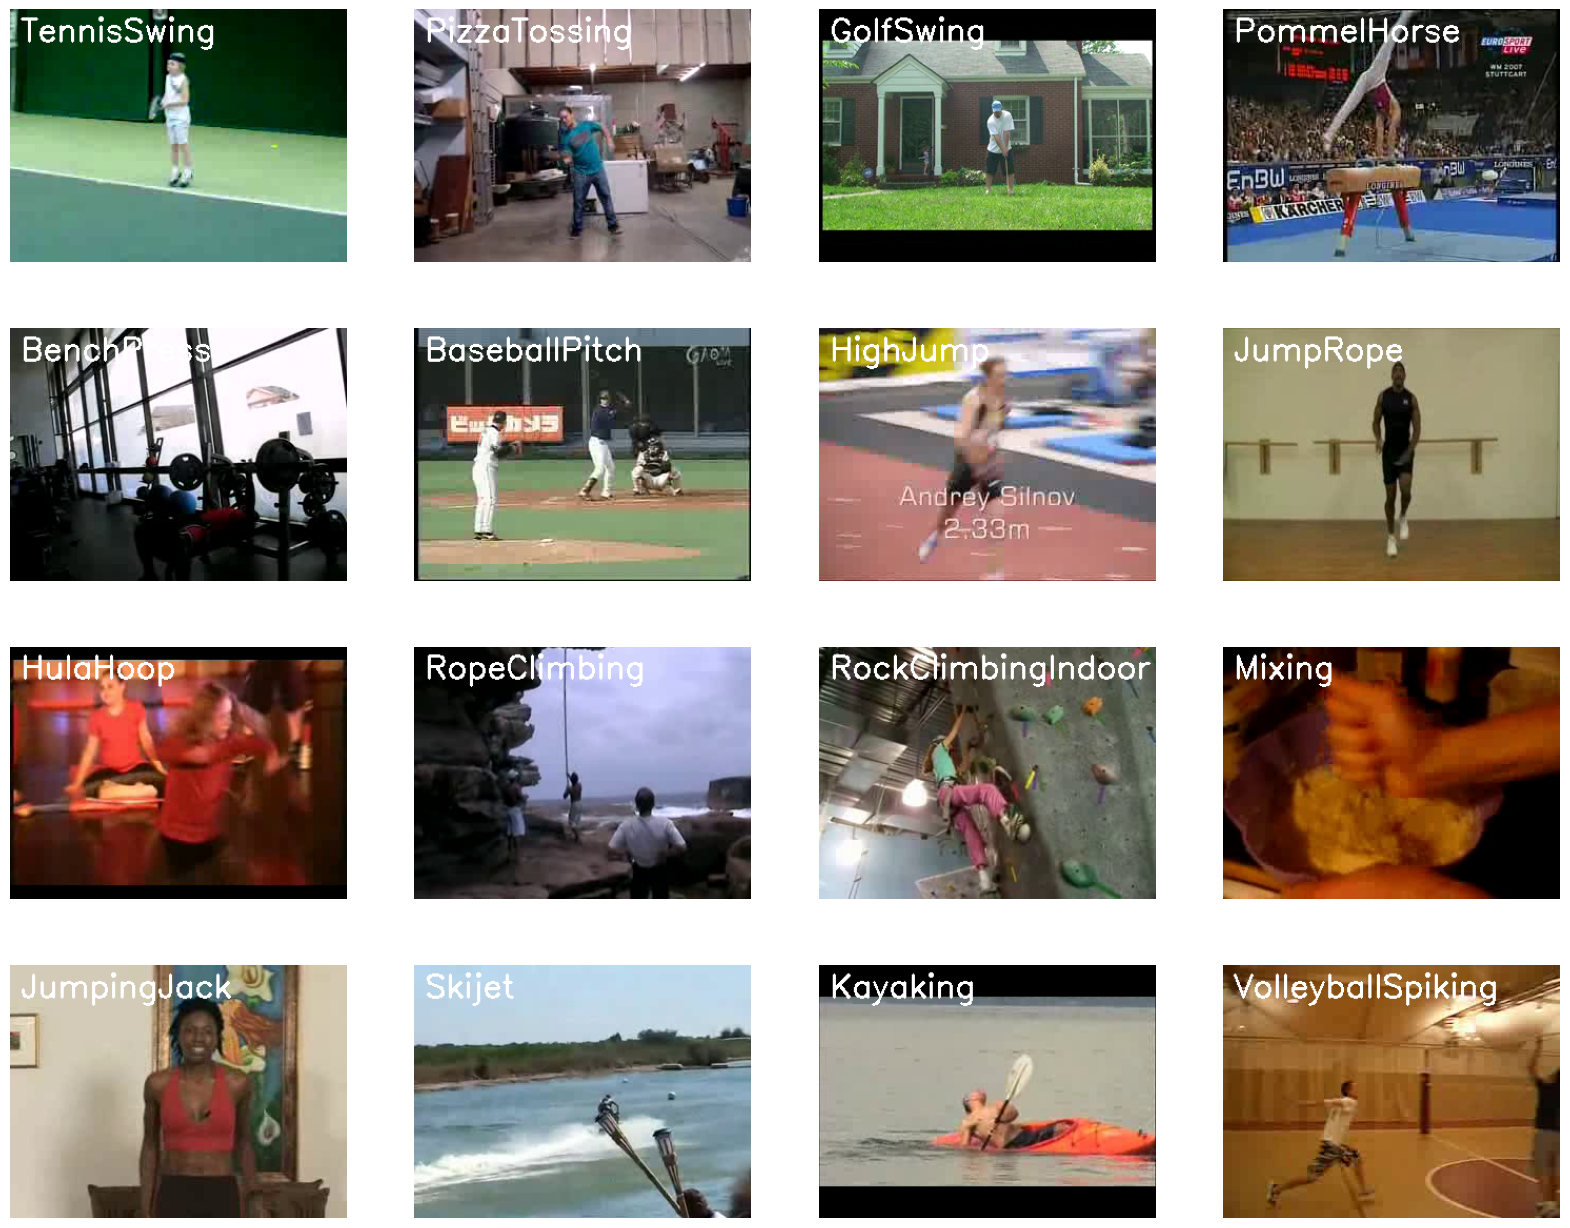

In [6]:
# Create a matplotlib and specifying size of the image
plt.figure(figsize= (20, 20))

#Get the names of all classes/categories in UCE58.
all_classes_names = os.listdir('UCF50')

##Generate a list of 20 random values. The values will be between 0-50,
#where 50 is the total number of class in the dataset.
random_range = random.sample(range(len(all_classes_names)), 16)

#Iterating through all the generated randon values.
for counter, random_index in enumerate(random_range, 1):

    #Retrieve a Class Name using the Random Index. 
    selected_class_Name = all_classes_names[random_index]

    #Retrieve the list of all the video files present in the randomly selected Class Directory. 
    video_files_names_list = os.listdir(f'UCF50/{selected_class_Name}')

    #Randomly select a video file from the list retrieved from the randomly selected Class Directory.
    selected_video_file_name = random.choice(video_files_names_list)

    #Initialize a VideoCapture object to read from the video File. 
    video_reader = cv2.VideoCapture(f'UCF50/{selected_class_Name}/{selected_video_file_name}')

    #Read the first frame of the video file 
    _, bgr_frame = video_reader.read()

    #Release the VideoCapture object.
    video_reader.release()

    #Convert the frame from BGR into RGB format.
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    #write the class name on the video frame. 
    cv2.putText(rgb_frame, selected_class_Name, (10,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    #Display the frame. 
    plt.subplot(5, 4, counter);plt.imshow(rgb_frame);plt.axis('off')

## **Step 2 - Pre-processing the dataset**

In [7]:
#Specify the height and width to which each vides frame will be resized in our dataset.
IMAGE_HEIGHT, IMAGE_WIDTH = 64,64

#Specify the of frames of a video that will be fed to the a as one sequence.#50
SEQUENCE_LENGTH = 20

#Specify the Directory containing the UCF50 dataset.
DATASET_DIR = "UCF50"

#Specify the list containing the names of the classes used for training. Feel free to choose any set of classes.
CLASSES_LIST = ["WalkingWithDog", "TaiChi", "Swing", "HorseRace"]

### **Creating a function to. Extract, Resize & Normalize Frames**:

In [8]:
def frames_extraction(video_path):
  
  """
  This function will extract the readred frames from a video after resizing and normalizing them.
  Args:
      video_path: The path of the video in the disk, whose frames are to be extracted.
  Returns:
      frames_list: A list containing the resized and normalized frames of the video.
  """
  #Declare a list to store video frames.
  frames_list = []
  
  #Read the Video File using the VideoCapture object.
  video_reader = cv2.VideoCapture(video_path)
  
  #Get the total number of frames in the video.
  video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
  
  #Calculate the the Interval after which frames will be added to the list.
  skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)
  
  #Iterate through the Video Frames
  for frame_counter in range(SEQUENCE_LENGTH):
    #Set the current frame position of the video,
    video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
    
    #Reading the frame from the video.
    success, frame = video_reader.read()

    #Check if Video frame is not successfully read then break the loop
    if not success:
      break
    
    #Resize the frame to fixed height and width.
    resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
    
    #Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
    normalized_frame = resized_frame / 255
    
    #Append the mrnalized frame into the frames list
    frames_list.append(normalized_frame)
    
  #Release the VideoCapture object.
  video_reader.release()
  
  #Returns The frames list.
  return frames_list

### **Create a function for dataset creation**

In [9]:
def create_dataset():
  #Declare empty list to store features,labels and video path values
  features = []
  labels = []
  video_file_paths = []

  for class_index,class_name in enumerate(CLASSES_LIST):

    print(f'Extractin data of class: {class_name}')

    files_list = os.listdir(os.path.join(DATASET_DIR,class_name))

    for file_name in files_list:

      video_file_path = os.path.join(DATASET_DIR,class_name,file_name)

      frames = frames_extraction(video_file_path)

      if len(frames) == SEQUENCE_LENGTH:

          features.append(frames)
          labels.append(class_index)
          video_file_paths.append(video_file_path)
        
  features = np.asarray(features)
  labels = np.asarray(labels)

  return features,labels,video_file_paths

In [10]:
features, labels, video_file_paths = create_dataset()

Extractin data of class: WalkingWithDog
Extractin data of class: TaiChi
Extractin data of class: Swing
Extractin data of class: HorseRace


In [11]:
one_hot_encoded_label = to_categorical(labels)

## **Step 3 - Split the dataset into train and test data**

In [12]:
features_train, features_test, labels_train, labels_test = train_test_split(features,one_hot_encoded_label,
                                                                            test_size=0.25, shuffle= True,
                                                                            random_state= seed_constant)

## **Step 4 - Implement ConvLSTM approach**

### **Construct the Model**

In [13]:
def create_convlstm_model():

  model = Sequential()

  model.add(ConvLSTM2D(filters = 4, kernel_size= (3,3), activation = 'tanh', data_format="channels_last",
                       recurrent_dropout = 0.2, return_sequences = True, input_shape = (SEQUENCE_LENGTH,
                                                                                        IMAGE_HEIGHT,IMAGE_WIDTH,3)))
  model.add(MaxPooling3D(pool_size = (1,2,2), padding = 'same', data_format= 'channels_last'))
  model.add(TimeDistributed(Dropout(0.2)))

  model.add(ConvLSTM2D(filters = 8, kernel_size= (3,3), activation = 'tanh', data_format="channels_last",
                       recurrent_dropout = 0.2, return_sequences = True))
  
  model.add(MaxPooling3D(pool_size = (1,2,2), padding = 'same', data_format= 'channels_last'))
  model.add(TimeDistributed(Dropout(0.2)))

  model.add(ConvLSTM2D(filters = 14, kernel_size= (3,3) , activation = 'tanh', data_format="channels_last",
                       recurrent_dropout = 0.2, return_sequences = True))
  
  model.add(MaxPooling3D(pool_size = (1,2,2), padding = 'same', data_format= 'channels_last'))
  model.add(TimeDistributed(Dropout(0.2)))

  model.add(ConvLSTM2D(filters = 16, kernel_size= (3,3), activation = 'tanh', data_format="channels_last",
                       recurrent_dropout = 0.2, return_sequences = True))
  model.add(MaxPooling3D(pool_size = (1,2,2), padding = 'same', data_format= 'channels_last'))
  #model.add(TimeDistributed(Dropout (0.2)))

  model.add(Flatten())
  model.add(Dense(len(CLASSES_LIST), activation = "softmax"))

  model.summary()

  return model


In [14]:
convlstm_model = create_convlstm_model()
print('Model Created Successfully')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 20, 62, 62, 4)     1024      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 20, 31, 31, 4)    0         
 )                                                               
                                                                 
 time_distributed (TimeDistr  (None, 20, 31, 31, 4)    0         
 ibuted)                                                         
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 20, 29, 29, 8)     3488      
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 20, 15, 15, 8)    0         
 3D)                                                             
                                                        

### **Check Model Structure**

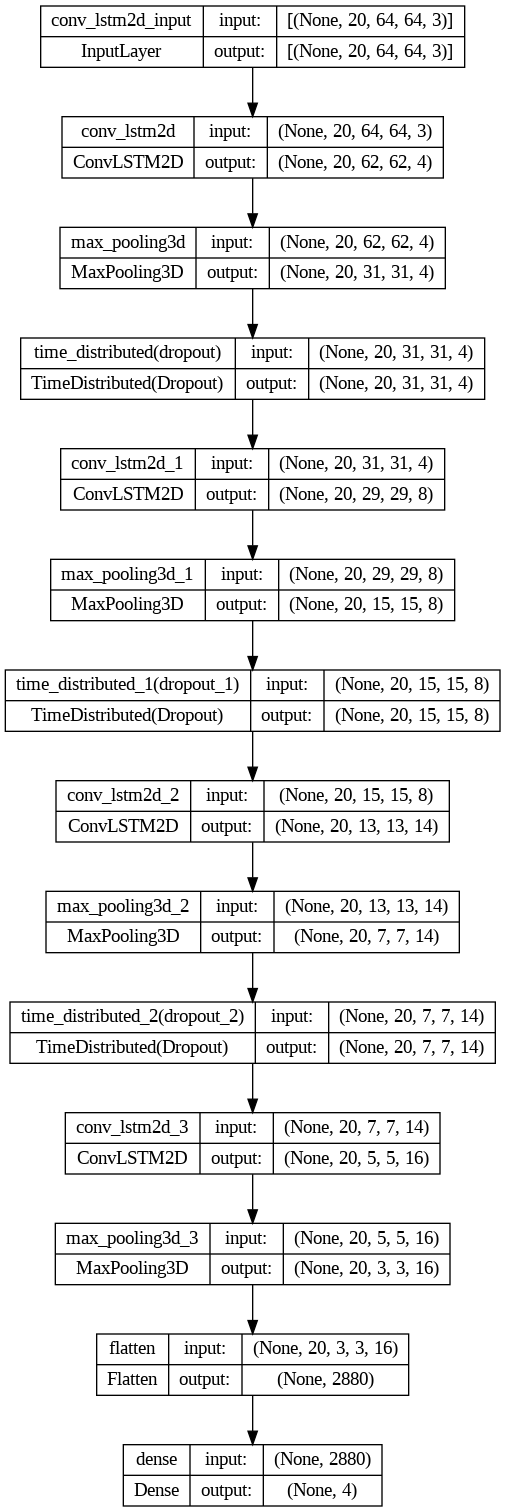

In [15]:
plot_model(convlstm_model, to_file = 'convlstm_model_structure_plot.png', show_shapes = True, show_layer_names = True)

### **Compile and train the model**

In [16]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights= True)

convlstm_model.compile(loss = 'categorical_crossentropy', optimizer= 'Adam', metrics =["accuracy"])

convlstm_model_training_history = convlstm_model.fit(x = features_train,  y = labels_train, epochs = 50, batch_size = 4,
                                                     shuffle = True, validation_split = 0.2,
                                                     callbacks =[early_stopping_callback])

Epoch 1/50
73/73 [==============================] - 40s 262ms/step - loss: 1.3862 - accuracy: 0.2740 - val_loss: 1.3757 - val_accuracy: 0.3562
Epoch 2/50
73/73 [==============================] - 19s 257ms/step - loss: 1.2967 - accuracy: 0.3870 - val_loss: 1.3033 - val_accuracy: 0.4110
Epoch 3/50
73/73 [==============================] - 18s 247ms/step - loss: 1.2006 - accuracy: 0.5000 - val_loss: 1.1767 - val_accuracy: 0.4932
Epoch 4/50
73/73 [==============================] - 18s 245ms/step - loss: 1.0593 - accuracy: 0.5514 - val_loss: 1.1871 - val_accuracy: 0.5068
Epoch 5/50
73/73 [==============================] - 19s 263ms/step - loss: 0.9341 - accuracy: 0.6096 - val_loss: 1.0705 - val_accuracy: 0.5616
Epoch 6/50
73/73 [==============================] - 18s 248ms/step - loss: 0.8319 - accuracy: 0.6507 - val_loss: 1.1579 - val_accuracy: 0.5479
Epoch 7/50
73/73 [==============================] - 19s 258ms/step - loss: 0.6695 - accuracy: 0.7363 - val_loss: 0.9375 - val_accuracy: 0.6164

### **Evaluate the Trained Model**

In [17]:
model_evaluation_history = convlstm_model.evaluate(features_test,labels_test)

4/4 [==============================] - 1s 126ms/step - loss: 0.7892 - accuracy: 0.7623


### **Save The Model**

In [18]:
model_evaluation_loss , model_evaluation_accuracy = model_evaluation_history

date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_String = dt.datetime.strftime(current_date_time_dt,date_time_format)

moddel_file_name = f'convlstm_model__Date_time_{current_date_time_String}__loss_{model_evaluation_loss}.h5'

convlstm_model.save(moddel_file_name)

### **Plot Model Loss and Accuracy Curves**

In [19]:
def plot_metric(convlstm_model_training_history,metric_name_1, metric_name_2, plot_name):

  metric_value_1 = convlstm_model_training_history.history[metric_name_1]
  metric_value_2 = convlstm_model_training_history.history[metric_name_2]

  epochs = range(len(metric_value_1))

  plt.plot(epochs, metric_value_1, 'blue',label = metric_name_1)
  plt.plot(epochs, metric_value_2, 'red',label = metric_name_2)

  plt.title(str(plot_name))

  plt.legend()

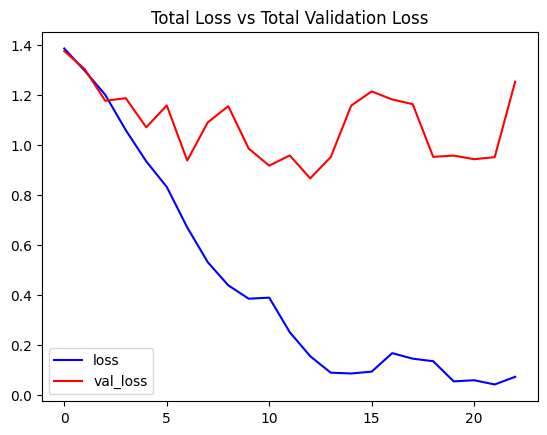

In [20]:
plot_metric(convlstm_model_training_history ,'loss','val_loss','Total Loss vs Total Validation Loss')

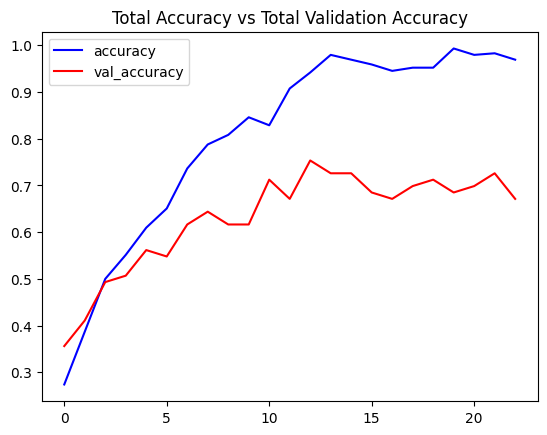

In [21]:
plot_metric(convlstm_model_training_history ,'accuracy','val_accuracy','Total Accuracy vs Total Validation Accuracy')

## **Step 5 - Implement the LRCN Approach**

### **Construct the model**

In [22]:
from keras.layers import TimeDistributed
from tensorflow import keras
from keras.layers import Conv2D
from keras.layers import Dense,Dropout, Activation
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Flatten

def create_LRCN_model():

  model = Sequential()

  model.add(TimeDistributed(Conv2D(16,(3,3), padding = 'same' , activation = 'relu'), 
                            input_shape = (SEQUENCE_LENGTH,IMAGE_HEIGHT,IMAGE_WIDTH,3)))
  
  model.add(TimeDistributed(MaxPooling2D((4,4))))
  model.add(TimeDistributed(Dropout(0.25)))

  model.add(TimeDistributed(Conv2D(32,(3,3), padding = 'same' , activation = 'relu')))
  model.add(TimeDistributed(MaxPooling2D((4,4))))
  model.add(TimeDistributed(Dropout(0.25)))

  model.add(TimeDistributed(Conv2D(64,(3,3), padding = 'same' , activation = 'relu')))
  model.add(TimeDistributed(MaxPooling2D((2,2))))
  model.add(TimeDistributed(Dropout(0.25)))

  model.add(TimeDistributed(Conv2D(64,(3,3), padding = 'same' , activation = 'relu')))
  model.add(TimeDistributed(MaxPooling2D((2,2))))
  #model.add(TimeDistributed(Dropout(0.25)))

  model.add(TimeDistributed(Flatten()))

  model.add(LSTM(32))

  model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))

  model.summary()

  return model
  

In [23]:
LRCN_model = create_LRCN_model()
print("Model created successfully")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_3 (TimeDis  (None, 20, 64, 64, 16)   448       
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 20, 16, 16, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_5 (TimeDis  (None, 20, 16, 16, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_6 (TimeDis  (None, 20, 16, 16, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, 20, 4, 4, 32)    

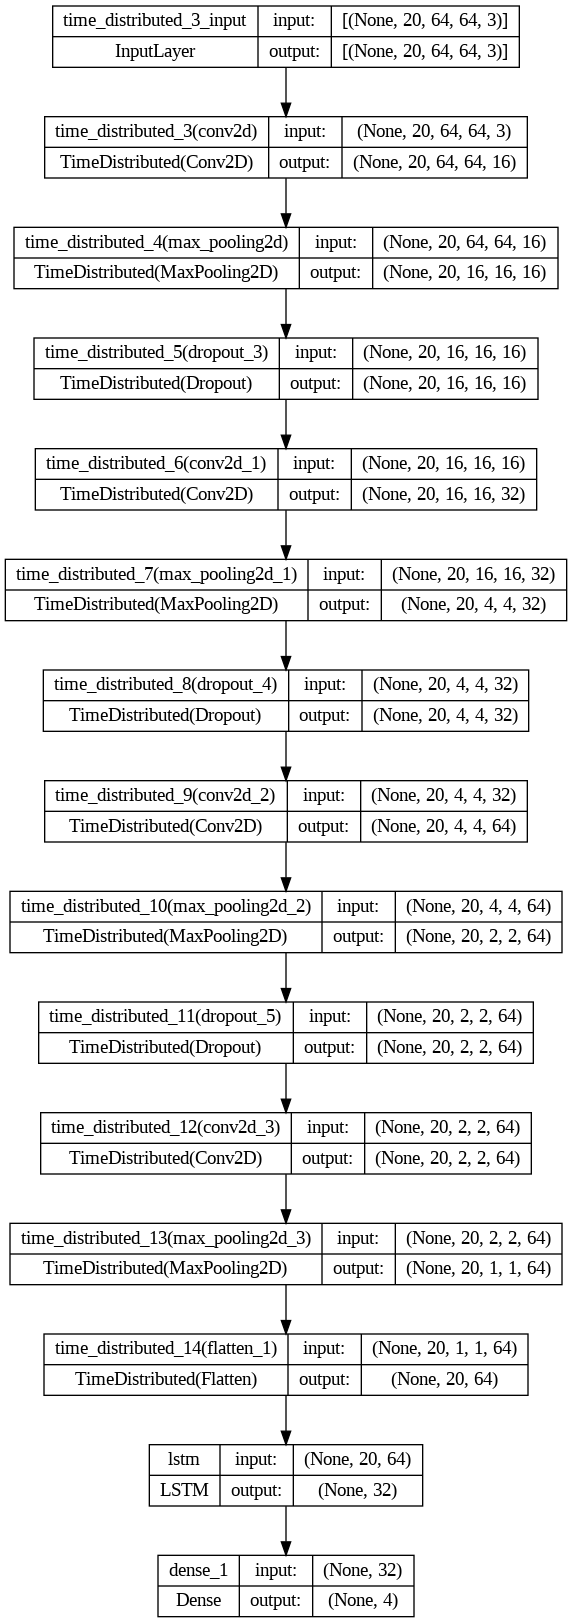

In [24]:
plot_model(LRCN_model, to_file='LRCN_model_structure_plot.png' , show_shapes= True, show_layer_names= True)

### **Compile & Train the Model**

In [25]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)

#Compile the model and specify loss function, optinizer and metries to the model.
LRCN_model.compile(loss = 'categorical_crossentropy', optimizer = "Adam", metrics = ["accuracy"])

#Start training the model.
LRCN_model_training_history = LRCN_model.fit(x = features_train, y = labels_train, epochs = 70, batch_size = 4, shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/70
73/73 [==============================] - 7s 25ms/step - loss: 1.3925 - accuracy: 0.3219 - val_loss: 1.3731 - val_accuracy: 0.2740
Epoch 2/70
73/73 [==============================] - 1s 12ms/step - loss: 1.3088 - accuracy: 0.4315 - val_loss: 1.2967 - val_accuracy: 0.4247
Epoch 3/70
73/73 [==============================] - 1s 13ms/step - loss: 1.1398 - accuracy: 0.5205 - val_loss: 1.1288 - val_accuracy: 0.5205
Epoch 4/70
73/73 [==============================] - 1s 13ms/step - loss: 0.9519 - accuracy: 0.6130 - val_loss: 0.9437 - val_accuracy: 0.5753
Epoch 5/70
73/73 [==============================] - 1s 12ms/step - loss: 0.7588 - accuracy: 0.6884 - val_loss: 0.8479 - val_accuracy: 0.7123
Epoch 6/70
73/73 [==============================] - 1s 16ms/step - loss: 0.6534 - accuracy: 0.7397 - val_loss: 1.0899 - val_accuracy: 0.5890
Epoch 7/70
73/73 [==============================] - 1s 16ms/step - loss: 0.6169 - accuracy: 0.7637 - val_loss: 0.6055 - val_accuracy: 0.8219
Epoch 8/70
73

### **Evaluate the trained Model**

In [26]:
model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)

4/4 [==============================] - 1s 80ms/step - loss: 0.5429 - accuracy: 0.7541


### **Save the Model**

In [27]:
model_evaluation_loss , model_evaluation_accuracy = model_evaluation_history

date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_String = dt.datetime.strftime(current_date_time_dt,date_time_format)

#Define a useful name for our model to make It easy for us while navigating through multiple saved models.

model_file_name = f'LRCN_model__Date_Time_(current_date_time_string)__ Loss_(model_evaluation_loss)__Accuracy_(model_evaluation_accuracy).h5'

#Save the Model.

LRCN_model.save(model_file_name)

### **Plot Model's Loss & Accuracy Curves**

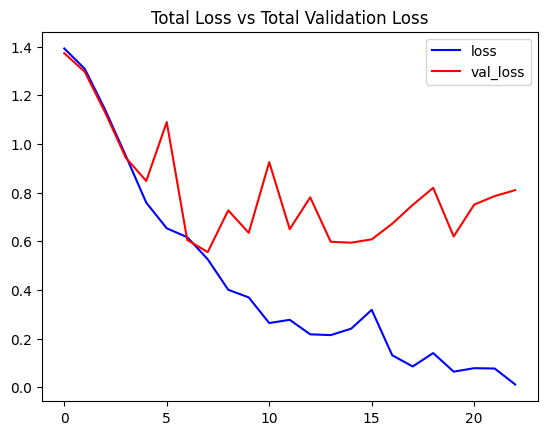

In [28]:
plot_metric(LRCN_model_training_history ,'loss','val_loss','Total Loss vs Total Validation Loss')

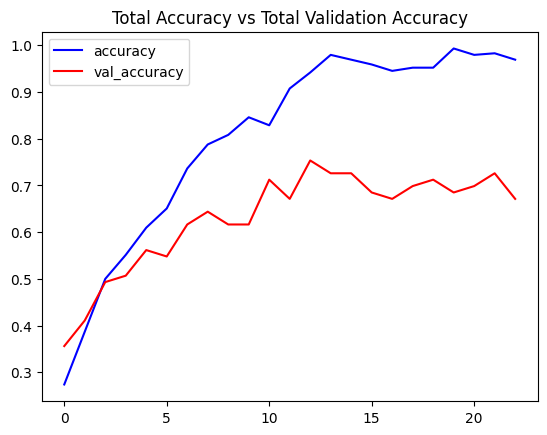

In [29]:
plot_metric(convlstm_model_training_history ,'accuracy','val_accuracy','Total Accuracy vs Total Validation Accuracy')

## **Step 6 - Test Model on YouTube Videos**

In [30]:
pip install git+https://github.com/nficano/pytube

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/nficano/pytube to /tmp/pip-req-build-4rbowhax
  Running command git clone --filter=blob:none --quiet https://github.com/nficano/pytube /tmp/pip-req-build-4rbowhax
  Resolved https://github.com/nficano/pytube to commit 96315dff218c3c5c4621997a5587f9d677774b97
  Preparing metadata (setup.py) ... done
  Created wheel for pytube: filename=pytube-12.1.3-py3-none-any.whl size=57202 sha256=62f4eea42c1c505148578a29fe097a6bfd51baf930418706988482a4b461bacc
  Stored in directory: /tmp/pip-ephem-wheel-cache-lznyh727/wheels/02/cc/85/f7d1949ee8bbe68c5fd0eb540e2d60d55faf7168f7c985bd1a
Successfully built pytube


### **Function to download YouTube Videos**

In [31]:
import pytube
def download_youtube_videos(youtube_video_url, output_directory):
  """
  This function downloads the youtube video whose URL is passed to it as an argument.
  Args:
    youtube video url: URL of the video that is required to be downloaded.
    output directory: The directory path to which the video needs to be stored after downloading.
  Returns:
   title: The title of the downloaded youtube video.
  """
  
  #Create video object which contains useful information about the video.
  #video = pafy.new(youtube_video_url)
  try:
        video = pytube.YouTube(youtube_video_url)
  except:
        print('Exception Occured')
        pass # Error loading single video
  else:
        #Retrieve the title of the video.
        title = video.title
        #Get the best available quality object for the video
        #video_best = video.getbest()
        #Construct the output file path.
        output_file_path = f'{output_directory}/{title}.mp4'
        video.streams.first().download(output_file_path)
  
  #Download the youtube video at the best quality and store it to the contructed path.

  #video_best.download(filepath = output_file_path, quiet = True)
  
  #Return the video title.
  return title

In [35]:
#Download a Test Video
test_videos_directory = 'test_videos'
os.makedirs(test_videos_directory, exist_ok= True)

video_title = download_youtube_videos('https://www.youtube.com/watch?v=8u0qjmHIOcE', test_videos_directory)

input_video_file_path = f'{test_videos_directory}/{video_title}.mp4'

In [36]:
os.listdir(test_videos_directory)

['Test Video.mp4']

In [37]:
os.listdir(input_video_file_path)

['Test Video.3gpp']

## **Create a function To Perform Action Recognition on Videos**

In [38]:
def predict_on_video(video_file_path, output_file_path, SEQUENCE_LENGTH):
  
  print(output_file_path)
  video_reader = cv2.VideoCapture(f'{video_file_path}/{video_title}.3gpp')
  
  #Get the width and height of the video.
  original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
  original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
  
  #Initialize the videriter Object to store the output video in the disk.
  video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'),
                                 video_reader.get(cv2.CAP_PROP_FPS), (original_video_width, original_video_height))
  
  #Declare queue to store video frames.
  frames_queue = deque(maxlen = SEQUENCE_LENGTH)
  
  #Initialize variable to store the predicted action being performed in the video
  predicted_class_name = ''

  # Iterate until the video is accessed successfully.
  while video_reader.isOpened():
    
    #Read the frame.
    ok, frame = video_reader.read()
    
    #Check if frame is not read properly then break the loop.
    if not ok:
      break
    
    #Resize the Frame to fixed Dimensions.
    resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
    
    # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1.
    normalized_frame = resized_frame / 255
    
    frames_queue.append(normalized_frame)
    
    if len(frames_queue) == SEQUENCE_LENGTH:

      # Pass the normalized frames to the model and get the predicted probabilities.
      predicted_labels_probabilities = LRCN_model.predict(np.expand_dims(frames_queue, axis= 0))[0]

      #Get the index of class with highest probability.
      predicted_label = np.argmax(predicted_labels_probabilities)

      #Get the class name using the retrieved index.
      predicted_class_name = CLASSES_LIST[predicted_label]
      
    #write predicted class name on top of the frame.
    cv2.putText(frame, predicted_class_name, (5, 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    #write frame into disk using Videowriter Object
    video_writer.write(frame)
  video_reader.release()
  video_writer.release() 

### **Perform Action Recognition on Test Video**

In [39]:
#Construct the output video path.
output_video_file_path = f'{test_videos_directory}/{video_title}-Output-Seqlen{SEQUENCE_LENGTH}.mp4'
#Perform Action Recognition on the Test Video.
predict_on_video(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH)
#Display the output video
VideoFileClip(output_video_file_path, audio = False, target_resolution = (300, None)).ipython_display()

test_videos/Test Video-Output-Seqlen20.mp4
1/1 [==============================] - 0s 25ms/step
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


### **Function to perform single prediction on videos**

In [40]:
def predict_single_action(video_file_path, SEQUENCE_LENGTH):
  
  #Initialize the VideoCapture object to read from the video file.
  video_reader = cv2.VideoCapture(f'{video_file_path}/{video_title}.3gpp')
  os.listdir(video_file_path)
  #Get the width and height of the video.
  original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
  original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
  
  #Declare a list to store video frames we will extract. 
  frames_list = []
  
  #Initialize a variable to store the predicted action being performed in the video.
  predicted_class_name = ''
  
  # Get the number of frases in the video.
  video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
  
  #Calculate the interval after which frases will be added to the list.
  skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH),1)
  
  #Iterating the number of times equal to the fixed length of sequence.
  for frame_counter in range(SEQUENCE_LENGTH):
    
    # Set the current frame position of the video
    video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
    
    #Read a frame.
    success, frame = video_reader.read()
    
    #Check if frame is not read properly then break the loop.
    if not success:
      break
    
    #Resize the Frane to fixed Dimensions.
    resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
    
    #Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1.
    normalized_frame = resized_frame/ 255
    
    #Appending the pre-processed frame into the frames list
    frames_list.append(normalized_frame)
  
  #Passing the pre-processed frames to the model and get the predicted probabilities.
  predicted_labels_probabilities = LRCN_model.predict(np.expand_dims(frames_list, axis= 0))[0]
  
  #Get the index of class with highest probability.
  predicted_label = np.argmax(predicted_labels_probabilities)
  
  #Get the class name using the retrieved Index
  predicted_class_name = CLASSES_LIST[predicted_label]
  
  #Display the predicted action along with the prediction confidence.
  print(f'Action Predicted: {predicted_class_name}\nConfidence: {predicted_labels_probabilities[predicted_label]}')
  
  #Release the videoCapture object
  video_reader.release()

### **Perform single prediction on test video**

In [41]:
# Download the youtube video.
video_title = download_youtube_videos ('https://www.youtube.com/watch?v=ceRjxW4MpOY', test_videos_directory)

# Construct tihe nput youtube video path
input_video_file_path = f'{test_videos_directory}/{video_title}.mp4'
os.listdir(input_video_file_path)

#Perform Single Prediction on the Test Video.
predict_single_action(input_video_file_path, SEQUENCE_LENGTH)

#Display the input video.
VideoFileClip(input_video_file_path, audio = False, target_resolution=(300, None)). ipython_display()

1/1 [==============================] - 0s 24ms/step
Action Predicted: TaiChi
Confidence: 0.8685006499290466


OSError: ignored